In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Question 1 - Even/Odd - integer.txt

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [ ]:
spark = SparkSession.builder.appName("Assignment2").getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions", 4)

In [ ]:
df_1 = spark.read.text("integer.txt")

In [ ]:
even_count = df_1.filter(df_1.value % 2 == 0).count()
odd_count = df_1.filter(df_1.value % 2 == 1).count()
print("Number of even integers:", even_count)
print("Number of odd integers:", odd_count)

Number of even integers: 514
Number of odd integers: 496


Question 2 - Salary Sum per Department - salary.txt

In [ ]:
df_2 = spark.read.format("csv").option("header", False).option("sep", " ").load("salary-1.txt")
df_2 = df_2.withColumnRenamed("_c0", "Department").withColumnRenamed("_c1", "Salary")
df_2 = df_2.withColumn("Salary",col("Salary").cast(IntegerType()))

In [ ]:
df_2.groupBy("Department").sum().show()

+----------+-----------+
|Department|sum(Salary)|
+----------+-----------+
|     Sales|    3488491|
| Developer|    3221394|
|        QA|    3360624|
| Marketing|    3158450|
|  Research|    3328284|
+----------+-----------+



Question 3 - MapReduce with Pyspark

In [ ]:
spark.stop()

In [ ]:
from pyspark import SparkContext
sc = SparkContext().getOrCreate()
spark = SparkSession(sc)

In [ ]:
book = sc.textFile("shakespeare-2.txt")
counts = book.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b)

In [ ]:
counts.filter(lambda KeyValue: KeyValue[0]=="Shakespeare" or KeyValue[0]=="why" \
              or KeyValue[0]=="Lord" or KeyValue[0]=="Library" or KeyValue[0]=="GUTENBERG" \
              or KeyValue[0]=="WILLIAM" or KeyValue[0]=="COLLEGE" or KeyValue[0]=="WORLD").toDF().show()

+-----------+---+
|         _1| _2|
+-----------+---+
|Shakespeare| 22|
|  GUTENBERG| 99|
|    WILLIAM|115|
|      WORLD| 98|
|    COLLEGE| 98|
|        why| 91|
|       Lord|341|
|    Library|  2|
+-----------+---+



Question 4 - Top 10 and Bottom 10 words

In [ ]:
def lower_clean_str(x):
  punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
  lowercased_str = x.lower()
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  return lowercased_str

book_clean_lower = book.map(lower_clean_str)

counts_clean_lower = book_clean_lower.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b)

In [ ]:
top = counts_clean_lower.toDF().orderBy('_2', ascending=False)
top.limit(11).show() # 11 words to not include " "

+----+------+
|  _1|    _2|
+----+------+
|    |231840|
| the| 13707|
| and| 12948|
|  of|  9371|
|   i|  9095|
|  to|  9079|
|   a|  6682|
| you|  6069|
|  my|  5696|
|  in|  5260|
|that|  5234|
+----+------+



In [ ]:
bottom = counts_clean_lower.toDF().orderBy('_2', ascending=True)
bottom.limit(10).show()

+------------+---+
|          _1| _2|
+------------+---+
|workswilliam|  1|
|    asterisk|  1|
|    produced|  1|
|        1994|  1|
| cooperation|  1|
|  guidelines|  1|
|      cdroms|  1|
|      online|  1|
|implications|  1|
|restrictions|  1|
+------------+---+



Part B - Movies

In [ ]:
df_B = spark.read.format("csv").option("header", True).option("sep", ",").load("movies.csv")
# Convert values to integer
df_B = df_B.withColumn("movieId",col("movieId").cast(IntegerType())).withColumn("rating",col("rating").cast(IntegerType())).withColumn("userId",col("userId").cast(IntegerType()))

In [ ]:
df_B.show()

+-------+------+------+
|movieId|rating|userId|
+-------+------+------+
|      2|     3|     0|
|      3|     1|     0|
|      5|     2|     0|
|      9|     4|     0|
|     11|     1|     0|
|     12|     2|     0|
|     15|     1|     0|
|     17|     1|     0|
|     19|     1|     0|
|     21|     1|     0|
|     23|     1|     0|
|     26|     3|     0|
|     27|     1|     0|
|     28|     1|     0|
|     29|     1|     0|
|     30|     1|     0|
|     31|     1|     0|
|     34|     1|     0|
|     37|     1|     0|
|     41|     2|     0|
+-------+------+------+
only showing top 20 rows



The data is sorted by user (labelled 0-29), in which they provide a rating (1-5) for a specific movie (labelled 1-99) and lists every movie they rated. 

Displaying the top 20 movies with the highest (most numbers of) rating

In [ ]:
from pyspark.sql import functions as F
movie_rating = df_B.drop('userId').withColumn("rating",col("rating").cast(IntegerType())).groupBy('movieId').agg(F.mean('rating'), F.count('rating'))
movie_rating.orderBy('count(rating)', ascending=False).limit(20).show()

+-------+------------------+-------------+
|movieId|       avg(rating)|count(rating)|
+-------+------------------+-------------+
|      6|              1.45|           20|
|     22|              2.05|           20|
|     51|               2.0|           20|
|     50|               1.8|           20|
|     29|               2.4|           20|
|     94| 2.473684210526316|           19|
|     15|1.1578947368421053|           19|
|     55|1.7894736842105263|           19|
|     68|2.1578947368421053|           19|
|      2|2.1052631578947367|           19|
|     86|1.1666666666666667|           18|
|     85|               2.0|           18|
|     88|2.0555555555555554|           18|
|     45|1.3333333333333333|           18|
|     14|               1.5|           18|
|     36|1.8333333333333333|           18|
|     82| 1.411764705882353|           17|
|     54|1.5294117647058822|           17|
|     95|1.9411764705882353|           17|
|      4|1.7647058823529411|           17|
+-------+--

Displaying the top 15 users who provided the highest (most number of) ratings

In [ ]:
user_rating = df_B.drop('movieId').withColumn("rating",col("rating").cast(IntegerType())).groupBy('userId').agg(F.mean('rating'), F.count('rating'))
user_rating.orderBy('count(rating)', ascending=False).limit(15).show()

+------+------------------+-------------+
|userId|       avg(rating)|count(rating)|
+------+------------------+-------------+
|     6|1.4385964912280702|           57|
|    14|1.7894736842105263|           57|
|    22|2.1607142857142856|           56|
|    11|2.2857142857142856|           56|
|    12|1.8545454545454545|           55|
|     4|1.5636363636363637|           55|
|     7|1.6296296296296295|           54|
|     9|1.7924528301886793|           53|
|    23|2.1346153846153846|           52|
|    24|1.8846153846153846|           52|
|    18|1.7307692307692308|           52|
|    28|              1.82|           50|
|    26| 2.204081632653061|           49|
|     1|1.5510204081632653|           49|
|     5|1.7755102040816326|           49|
+------+------------------+-------------+



Split data set into train and test and use collaborative filtering approach, this will recommend movies based on similar users

In [ ]:
(training_1, test_1) = df_B.randomSplit([0.6, 0.4], seed=0)
(training_2, test_2) = df_B.randomSplit([0.8, 0.2], seed=0)

In [ ]:
# From Lecture Notes - Lecture #4

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

als = ALS(userCol= "userId", itemCol= "movieId", ratingCol="rating", coldStartStrategy = "drop")
parameters=ParamGridBuilder().build() #Parameters left as default values for now

# Evaluating using RMSE and MAE
eval = RegressionEvaluator(metricName= "rmse", labelCol= "rating", predictionCol= "prediction")
evalMAE = RegressionEvaluator(metricName= "mae", labelCol= "rating", predictionCol= "prediction")
trainvs = TrainValidationSplit(estimator=als, estimatorParamMaps=parameters, evaluator=eval)
trainvsMAE = TrainValidationSplit(estimator=als, estimatorParamMaps=parameters, evaluator=evalMAE)

# Create model by fitting training data using RMSE and MAE
model_1 = trainvs.fit(training_1)
model_2 = trainvs.fit(training_2)
model_1_MAE = trainvsMAE.fit(training_1)
model_2_MAE = trainvsMAE.fit(training_2)

# Create predictions based on different train/split percentages and evaluation metrics
predictions_1 = model_1.transform(test_1)
predictions_2 = model_2.transform(test_2)
predictions_1_MAE = model_1_MAE.transform(test_1)
predictions_2_MAE = model_2_MAE.transform(test_2)

rmse_1 = eval.evaluate(predictions_1)
rmse_2 = eval.evaluate(predictions_2)
mae_1 = evalMAE.evaluate(predictions_1_MAE)
mae_2 = evalMAE.evaluate(predictions_2_MAE)

In [ ]:
print("RMSE for 60/40 split:", rmse_1)
print("RMSE for 80/20 split:", rmse_2)
print("MAE for 60/40 split:", mae_1)
print("MAE for 80/20 split:", mae_2)

RMSE for 60/40 split: 1.0250791320358963
RMSE for 80/20 split: 0.9128798297678604
MAE for 60/40 split: 0.7273204656601342
MAE for 80/20 split: 0.6705189694960912


MAE is Mean Absolute Error, it calculates the absolute distance between the dataset and its prediction on  a regression, and takes the average over all the observations. 

MSE is Mean Squared Error, similar to MAE but it squares the distance to take account of the negatives. Higher errors weight/contribute more to the scale, although you are provided units that are squared which may not always make sense.

RMSE is Root Mean Squared Error, this returns the MSE error to the original unit by taking the square root, while still penalizing higher errors

Which metrics works better depends on the scenario, RMSE works better at detecting outliers which may be more useful in this case since you do not want to recommend an outlier movie to a user (for example, a horror movie to a kid), there's also multiple movies being recommend to the user so the user will have multiple selections

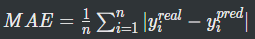

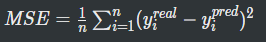

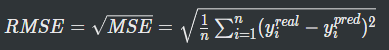

Will use 80/20 split since it provided a lower RMSE value

In [ ]:
parameters_tuned=ParamGridBuilder()\
.addGrid(als.rank,[10, 50])\
.addGrid(als.maxIter, [10, 15])\
.addGrid(als.regParam, [0.01, 1.0])\
.build()

cv = CrossValidator(estimator=als, estimatorParamMaps=parameters_tuned, evaluator=eval, numFolds=3) #Cross validation folds
model_tuned_2 = cv.fit(training_2)
best_model_2 = model_tuned_2.bestModel
predictions_tuned_2 = best_model_2.transform(test_2) 
rmse_tuned_2 = eval.evaluate(predictions_tuned_2)

numBlocks default is 10 - partition size

Default rank is 10, rank is the number of hidden/latent factors in the model, size of feature vectors

maxIter default is 10, number of iterations to run

regParam default is 1.0, regularization parameter

lambda default is 0.01, regularization parameter in ALS

implicitprefs default is false which means it's using explicit feedback

alpha default is 1.0, only used when implicit feedback is used

In [ ]:
print("RMSE for tuned 80/20 split:", rmse_tuned_2)

RMSE for tuned 80/20 split: 1.192991649366354


It seems that the tuned model gave a higher RMSE value compared to the default parameters, this might mean that our model is overfitting the hyperparameters to the training data. 

In [ ]:
# Listing the best hyperparameters
print("Best Model Parameters:")
print("Rank:", best_model_2._java_obj.parent().getRank())
print("MaxIter:", best_model_2._java_obj.parent().getMaxIter())
print("RegParam:", best_model_2._java_obj.parent().getRegParam())

Best Model Parameters:
Rank: 50
MaxIter: 15
RegParam: 0.01


In [ ]:
user = spark.createDataFrame(["10","14"], "string").toDF("userId")
recommendations = best_model_2.recommendForUserSubset(user,15)
top_15_recommendations = recommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))
top_15_recommendations.show(30)

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|    10|      2|3.9862168|
|    10|     49|2.9929516|
|    10|     25|2.9872494|
|    10|     89|2.9810855|
|    10|     42|2.9478023|
|    10|     12|2.9046667|
|    10|      0|2.8857148|
|    10|     92| 2.746862|
|    10|     81|2.2664208|
|    10|     82| 2.100837|
|    10|     16|1.9828173|
|    10|     55|1.9712551|
|    10|     58| 1.676159|
|    10|     19|1.5580031|
|    10|     53|1.5444444|
|    14|     29|4.9799075|
|    14|     76|4.9720674|
|    14|     63|4.9576497|
|    14|     72|3.9752908|
|    14|     96|3.9670722|
|    14|     62|3.9329147|
|    14|     53|3.0333498|
|    14|     69|2.9924703|
|    14|     93| 2.975674|
|    14|     67|2.9732895|
|    14|     14|2.9582562|
|    14|     31|2.9569626|
|    14|     25|2.5066688|
|    14|     52|2.4047182|
|    14|     43| 2.313209|
+------+-------+---------+

